In [1]:
!pip install mne

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html -U

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/nightly/cu111/torch_nightly.html


In [3]:
######################################################################################################
#  ________   _________   ___    ___ ___  ___  ________  ________  ___  __      _______   _______
# |\   ___  \|\___   ___\|\  \  /  /|\  \|\  \|\   __  \|\   ____\|\  \|\  \   /  ___  \ /  ___  \
# \ \  \\ \  \|___ \  \_|\ \  \/  / | \  \\\  \ \  \|\  \ \  \___|\ \  \/  /|_/__/|_/  //__/|_/  /|
#  \ \  \\ \  \   \ \  \  \ \    / / \ \   __  \ \   __  \ \  \    \ \   ___  \__|//  / /__|//  / /
#   \ \  \\ \  \   \ \  \  /     \/   \ \  \ \  \ \  \ \  \ \  \____\ \  \\ \  \  /  /_/__  /  /_/__
#    \ \__\\ \__\   \ \__\/  /\   \    \ \__\ \__\ \__\ \__\ \_______\ \__\\ \__\|\________\\________\
#     \|__| \|__|    \|__/__/ /\ __\    \|__|\|__|\|__|\|__|\|_______|\|__| \|__| \|_______|\|_______|
#                        |__|/ \|__|
######################################################################################################
#
# Data exploration and example file for submission in the NTX Hackathon challenge
#
######################################################################################################

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.pipeline import make_pipeline
from mne.decoding import Vectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [5]:
# Path to training data
train_path = "/home/deepak/learning_project/student/BrainAge/training/"

In [6]:
# Path to testing data (public test set)
test_path = "/home/deepak/learning_project/student/BrainAge/testing_flat/"

In [7]:
# download data https://filesender.renater.fr/?s=download&token=e1de0ec4-09bc-4194-b85b-59830cb04af3
# download test data from https://codalab.lisn.upsaclay.fr/competitions/8336

condition_ec = "EC"  # use only closed eyes condition for demonstration purpose
condition_eo = "EO"  # use only closed eyes condition for demonstration purpose
train_subj = 1200  # use 10 instead of 1200 training subjects, for demonstration purpose
test_subj = 400  # use 10 instead of 400 testing subjects, for demonstration purpose

In [8]:
class CustomDataset(Dataset):
    def __init__(self, path, subj, ages, start):
        self.path = path
        self.subj = subj
        self.ages = ages
        self.start = start
    def __len__(self):
        return self.subj
    def __getitem__(self, idx):
        s = idx + self.start
        fname = f"subj{s:04}_{condition_eo}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_eo = torch.zeros(129, 10000)
        data_eo[:, :ft] = torch.tensor(d)
        fname = f"subj{s:04}_{condition_ec}_raw.fif.gz"
        raw = mne.io.read_raw(self.path + fname, preload=True, verbose='warning')
        d = raw.get_data()
        ft = d.shape[-1]
        data_ec = torch.zeros(129, 20000)
        data_ec[:, :ft] = torch.tensor(d)
        data = (data_eo, data_ec)
        age = self.ages[idx]
        return data, age

In [9]:
# get the age to predict from the CSV file
meta = pd.read_csv(train_path + "train_subjects.csv")
y_train = []
for age in meta["age"][:train_subj]:
    y_train.append(age)

In [10]:
train_data = CustomDataset(train_path, train_subj, y_train, 1)

In [11]:
test_ages = [0 for i in range(test_subj)]
test_data = CustomDataset(test_path, test_subj, test_ages, 1201)

In [12]:
# DataLoader
batch_size = 8

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    num_workers=2
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    num_workers=2
)

In [13]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device(DEVICE)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3870000, out_features=64, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=64, out_features=32, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=16, out_features=8, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1 ,inplace=False),
            nn.Linear(in_features=8, out_features=1, bias=True)
        )
    def forward(self, x):
        return self.classifier(x)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = torch.device(DEVICE)
        self.features_eo = nn.Sequential(  # input shape = (batch_size, 129, 10000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # shape = (batch_size, 129, 10000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # shape = (batch_size, 129, 10000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
            # shape = (batch_size, 129, 10000)
        )
        self.features_ec = nn.Sequential(  # input shape = (batch_size, 129, 20000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # shape = (batch_size, 129, 20000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            # shape = (batch_size, 129, 20000)
            nn.Conv1d(in_channels=129, out_channels=129, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
            # shape = (batch_size, 129, 10000)
        )
        self.features = nn.Sequential(  # input shape = (batch_size, 258, 10000)
            nn.Conv1d(in_channels=258, out_channels=129, kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            # shape = (batch_size, 129, 10000)
            nn.Conv1d(in_channels=129, out_channels=60, kernel_size=30, stride=2, padding=14),
            nn.ReLU(),
            # shape = (batch_size, 60, 5000)
            nn.Conv1d(in_channels=60, out_channels=30, kernel_size=45, stride=5, padding=20),
            nn.ReLU(),
            # shape = (batch_size, 30, 1000)
        )
        self.avgpool = nn.AvgPool1d(kernel_size=2)
        self.classifier = nn.Sequential(  # input shape = (batch_size, 30, 500)
            nn.Flatten(),
            nn.Linear(in_features=15000, out_features=8192, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=8192, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=2048, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=2048, out_features=1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4, inplace=False),
            nn.Linear(in_features=128, out_features=32, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(in_features=32, out_features=16, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=16, out_features=8, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=8, out_features=4, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4, out_features=2, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=2, out_features=1, bias=True),
            nn.ReLU(inplace=True)
        )
    def forward(self, x_eo, x_ec):
        x_eo = self.features_eo(x_eo)
        x_ec = self.features_ec(x_ec)
        x = torch.cat((x_eo, x_ec), 1)
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [15]:
model_CNN = CNN()
model_CNN = model_CNN.to(DEVICE)

In [16]:
from torchsummary import summary

summary(model_CNN, [(129, 10000), (129, 20000)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1           [-1, 129, 10000]          50,052
              ReLU-2           [-1, 129, 10000]               0
            Conv1d-3           [-1, 129, 10000]          83,334
              ReLU-4           [-1, 129, 10000]               0
            Conv1d-5           [-1, 129, 10000]          83,334
              ReLU-6           [-1, 129, 10000]               0
            Conv1d-7           [-1, 129, 20000]          50,052
              ReLU-8           [-1, 129, 20000]               0
            Conv1d-9           [-1, 129, 20000]          83,334
             ReLU-10           [-1, 129, 20000]               0
           Conv1d-11           [-1, 129, 10000]          83,334
             ReLU-12           [-1, 129, 10000]               0
           Conv1d-13           [-1, 129, 10000]         499,359
             ReLU-14           [-1, 129

In [17]:
def train(model, device, train_loader, lr, epochs):
    loss_log = []
    model.train()
    lossfunc = nn.L1Loss(reduction='mean')
    optimizer = torch.optim.NAdam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        running_loss = 0.0
        print(f"Epoch #{1 + epoch:02}: ", end="")
        for data, age in train_loader:
            data_eo, data_ec = data
            data_eo = data_eo.to(device)           # shape = (batch_size, 129, 10000)
            data_ec = data_ec.to(device)           # shape = (batch_size, 129, 20000)
            age = age.to(device)                   # shape = (batch_size)
            batch_size = age.size(0)
#             x = torch.cat((data_eo, data_ec), -1)  # shape = (batch_size, 129, 30000)
            optimizer.zero_grad()
            output = model(data_eo, data_ec)
            loss = lossfunc(torch.squeeze(output), age)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_size
        running_loss /= train_subj
        loss_log.append(running_loss)
        print(running_loss)
    plt.plot(loss_log)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    return loss_log

Epoch #01: 10.532821912018656
Epoch #02: 9.706310445146089
Epoch #03: 9.262004995099034
Epoch #04: 8.705797478955313
Epoch #05: 8.038646100462799
Epoch #06: 7.263184878926798
Epoch #07: 6.382019914886679
Epoch #08: 5.401045404540202
Epoch #09: 4.443217607626595
Epoch #10: 3.7202203125191757
Epoch #11: 3.2596132013836914
Epoch #12: 3.0063926336922204
Epoch #13: 2.8888418278967287
Epoch #14: 2.836267016687724
Epoch #15: 2.8151888126641853
Epoch #16: 2.805501266892954
Epoch #17: 2.8015426761795044
Epoch #18: 2.8004096660059097
Epoch #19: 2.800183709136962
Epoch #20: 2.800156599101969
Epoch #21: 2.800200721387634
Epoch #22: 2.8002200142190548
Epoch #23: 2.800237901970316
Epoch #24: 2.800254646901855
Epoch #25: 2.839261813672988
Epoch #26: 2.919369620141653
Epoch #27: 2.8055308530231535
Epoch #28: 2.8011150468524164
Epoch #29: 2.800964450915171
Epoch #30: 2.799224646571096


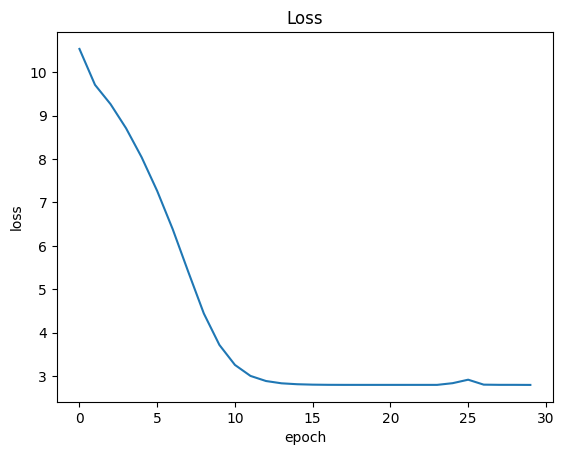

In [18]:
loss_log = train(model_CNN, DEVICE, train_loader, 0.001, 30)

In [19]:
loss_log

[10.532821912018656,
 9.706310445146089,
 9.262004995099034,
 8.705797478955313,
 8.038646100462799,
 7.263184878926798,
 6.382019914886679,
 5.401045404540202,
 4.443217607626595,
 3.7202203125191757,
 3.2596132013836914,
 3.0063926336922204,
 2.8888418278967287,
 2.836267016687724,
 2.8151888126641853,
 2.805501266892954,
 2.8015426761795044,
 2.8004096660059097,
 2.800183709136962,
 2.800156599101969,
 2.800200721387634,
 2.8002200142190548,
 2.800237901970316,
 2.800254646901855,
 2.839261813672988,
 2.919369620141653,
 2.8055308530231535,
 2.8011150468524164,
 2.800964450915171,
 2.799224646571096]

In [22]:
def test(model, device, test_loader):
    y_pred = []
    for data, age in test_loader:
        data_eo, data_ec = data
        data_eo = data_eo.to(device)           # shape = (batch_size, 129, 10000)
        data_ec = data_ec.to(device)           # shape = (batch_size, 129, 20000)
#         x = torch.cat((data_eo, data_ec), -1)  # shape = (batch_size, 129, 30000)
        output = torch.squeeze(model(data_eo, data_ec))
        print(output.shape)
        y_pred.extend(list(output.detach().cpu().numpy()))
    return y_pred

In [23]:
y_pred = test(model_CNN, DEVICE, test_loader)

torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([8])


In [24]:
# create submission file
submission = []
for subj, pred in zip(range(1201, 1201 + test_subj), y_pred):
    submission.append({"id": subj, "age": pred})
pd.DataFrame(submission).to_csv("mysubmission4.csv", index=False)

# zip the csv file (without anything else) and submit it on the website!